In [2]:
from google.colab import drive
drive.mount('/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /drive


In [0]:
loc = '/drive/My Drive/Colab Notebooks/crypto_data/' 

In [0]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

from sklearn import preprocessing
from collections import deque

In [4]:
df = pd.read_csv(loc + 'ETH-USD.csv', names = ['time', 'low', 'high', 'open', 'close', 'volume'])
df.head()

,time,low,high,open,close,volume
0,1528968720,485.98999,486.5,486.019989,486.01001,26.019083
1,1528968780,486.00000,486.0,486.000000,486.00000,8.449400
2,1528968840,485.75000,486.0,486.000000,485.75000,26.994646
3,1528968900,485.75000,486.0,485.750000,486.00000,77.355759
4,1528968960,485.98999,486.0,486.000000,486.00000,7.503300


In [5]:
main_df = []
categories = ['ETH-USD', 'BTC-USD', 'BCH-USD', 'LTC-USD']
for category in categories:
  
  path = os.path.join(loc+category+'.csv')
  df = pd.read_csv(path, names = ['time', 'low', 'high', 'open', 'close', 'volume'])
  
  df.rename(columns={'close':f'{category}_close', 'volume':f'{category}volume'}, inplace = True)
  
  df.set_index('time', inplace=True)
  df = df[[f'{category}_close' , f'{category}volume']]
  
  if len (main_df) == 0:
    main_df = df
  else:
    main_df = main_df.join(df)


main_df.fillna(method = 'ffill', inplace = True)
main_df.dropna(inplace=True)
print(f'Total Data : {len(main_df)}','\n' ,main_df.head())

Total Data : 102831 
             ETH-USD_close  ETH-USDvolume  ...  LTC-USD_close  LTC-USDvolume
time                                      ...                              
1528968720      486.01001      26.019083  ...      96.660004     314.387024
1528968780      486.00000       8.449400  ...      96.570000      77.129799
1528968840      485.75000      26.994646  ...      96.500000       7.216067
1528968900      486.00000      77.355759  ...      96.389999     524.539978
1528968960      486.00000       7.503300  ...      96.519997      16.991997

[5 rows x 8 columns]


In [6]:
main_df.columns

Index(['ETH-USD_close', 'ETH-USDvolume', 'BTC-USD_close', 'BTC-USDvolume',
       'BCH-USD_close', 'BCH-USDvolume', 'LTC-USD_close', 'LTC-USDvolume'],
      dtype='object')

In [0]:
SEQ_LEN = 60 # how long of a preceeding sequence to collect for RNN
FUTURE_PREDICT = 3 # how far into the future are we trying to predict?
RATIO_TO_PREDICT = 'LTC-USD'

In [0]:
def classify(current,future):
  if float(current) < float(future) :
    return 1
  else:
    return 0

In [0]:
main_df['future'] = main_df[RATIO_TO_PREDICT+'_close'].shift(-FUTURE_PREDICT)

main_df['target'] = list(map(classify, main_df[RATIO_TO_PREDICT+'_close'], main_df['future']))

In [10]:
print(f'Total :{len(main_df)}')
print(main_df[[f'{RATIO_TO_PREDICT}_close', 'future' , 'target']].head(10))

Total :102831
            LTC-USD_close     future  target
time                                        
1528968720      96.660004  96.389999       0
1528968780      96.570000  96.519997       0
1528968840      96.500000  96.440002       0
1528968900      96.389999  96.470001       1
1528968960      96.519997  96.400002       0
1528969020      96.440002  96.400002       0
1528969080      96.470001  96.400002       0
1528969140      96.400002  96.400002       0
1528969200      96.400002  96.400002       0
1528969260      96.400002  96.449997       1


In [0]:
times = sorted(main_df.index.values) # get the times sorted

last_5percent = times[-int(0.05*len(times))]  # get the last 5% of the times

In [0]:
validation_main_df = main_df[(main_df.index >= last_5percent)] # validation dataa of last 5% 

main_df = main_df[(main_df.index < last_5percent)]

In [0]:
def preprocess_df(df):
  
  df = df.drop('future', 1) # don't need this anymore.
  
  for col in df.columns:
    if col != 'target': # normalize all ... except for the target itself!
      df[col] = df[col].pct_change()  # pct change "normalizes" the different currencies
      df.dropna(inplace=True)
      df[col] = preprocessing.scale(df[col].values)
  df.dropna(inplace=True)
  
  sequential_data = []
  prev_days = deque(maxlen = SEQ_LEN )  # These will be our actual sequences. They are made with deque, which keeps the maximum length by popping out older values as new ones come in
  

  for i in df.values: # iterate over the values
    prev_days.append([n for n in i[:-1]]) # store all but the target

    if len(prev_days) == SEQ_LEN:  # make sure we have 60 sequences!
            sequential_data.append([np.array(prev_days), i[-1]])  # append those bad boys!

  random.shuffle(sequential_data)

  buys = []  # list that will store our buy sequences and targets
  sells = []  # list that will store our sell sequences and targets

  for seq, target in sequential_data:  # iterate over the sequential data
      if target == 0:  # if it's a "not buy"
          sells.append([seq, target])  # append to sells list
      elif target == 1:  # otherwise if the target is a 1...
          buys.append([seq, target])  # it's a buy!

  random.shuffle(buys)  # shuffle the buys
  random.shuffle(sells)  # shuffle the sells!

  lower = min(len(buys), len(sells))  # what's the shorter length?

  buys = buys[:lower]  # make sure both lists are only up to the shortest length.
  sells = sells[:lower]  # make sure both lists are only up to the shortest length.

  sequential_data = buys+sells  # add them together
  random.shuffle(sequential_data)  # another shuffle, so the model doesn't get confused with all 1 class then the other.

  X = []
  y = []

  for seq, target in sequential_data:  # going over our new sequential data
      X.append(seq)  # X is the sequences
      y.append(target)  # y is the targets/labels (buys vs sell/notbuy)

  return np.array(X), y  # return X and y...and make X a numpy array!

In [0]:
X_train, y_train =  preprocess_df(main_df)

X_test, y_test = preprocess_df(validation_main_df)


In [18]:
print(f'Train Data : {len(X_train)}, Test Data : {len(y_train)}')
print(f'Buy : {y_train.count(1)}, Sell : {y_train.count(0)}')
print(f'Validation Buy : {len(y_test)}, Validation Sell : {y_test.count(0)}')

Train Data : 82166, Test Data : 82166
Buy : 41083, Sell : 41083
Validation Buy : 4018, Validation Sell : 2009


In [19]:
X_train.shape[:]

(82166, 60, 8)

# Model

for LTC-USD

In [20]:
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import  Dense,Dropout, LSTM, CuDNNLSTM, BatchNormalization

Using TensorFlow backend.


In [0]:
model = Sequential()
model.add(CuDNNLSTM(256, input_shape=(X_train.shape[1:]), return_sequences=True))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(CuDNNLSTM(256, return_sequences=True))
model.add(Dropout(0.1))
model.add(BatchNormalization())


model.add(CuDNNLSTM(256))
model.add(Dropout(0.2))
model.add(BatchNormalization())


model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(2, activation='softmax'))

In [93]:
model.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_67 (CuDNNLSTM)    (None, 60, 256)           272384    
_________________________________________________________________
dropout_71 (Dropout)         (None, 60, 256)           0         
_________________________________________________________________
batch_normalization_56 (Batc (None, 60, 256)           1024      
_________________________________________________________________
cu_dnnlstm_68 (CuDNNLSTM)    (None, 60, 256)           526336    
_________________________________________________________________
dropout_72 (Dropout)         (None, 60, 256)           0         
_________________________________________________________________
batch_normalization_57 (Batc (None, 60, 256)           1024      
_________________________________________________________________
cu_dnnlstm_69 (CuDNNLSTM)    (None, 256)             

In [0]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer = Adam(lr=0.01, decay = 1e-5),
              metrics = ['accuracy'])

In [95]:
ml = model.fit(X_train, y_train, epochs = 10, batch_size=64 ,validation_data=(X_test, y_test))

Train on 82166 samples, validate on 4018 samples
Epoch 1/10
82166/82166 [==============================] - 100s 1ms/step - loss: 0.7017 - acc: 0.5006 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 2/10
82166/82166 [==============================] - 95s 1ms/step - loss: 0.6935 - acc: 0.4981 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 3/10
82166/82166 [==============================] - 95s 1ms/step - loss: 0.6934 - acc: 0.5049 - val_loss: 0.6938 - val_acc: 0.5000
Epoch 4/10
82166/82166 [==============================] - 94s 1ms/step - loss: 0.6935 - acc: 0.4991 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 5/10
82166/82166 [==============================] - 94s 1ms/step - loss: 0.6935 - acc: 0.5015 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 6/10
82166/82166 [==============================] - 94s 1ms/step - loss: 0.6935 - acc: 0.4977 - val_loss: 0.6933 - val_acc: 0.5000
Epoch 7/10
82166/82166 [==============================] - 94s 1ms/step - loss: 0.6935 - acc: 0.4992 - val_loss: 0.6943 - val_acc

Text(0, 0.5, 'loss')

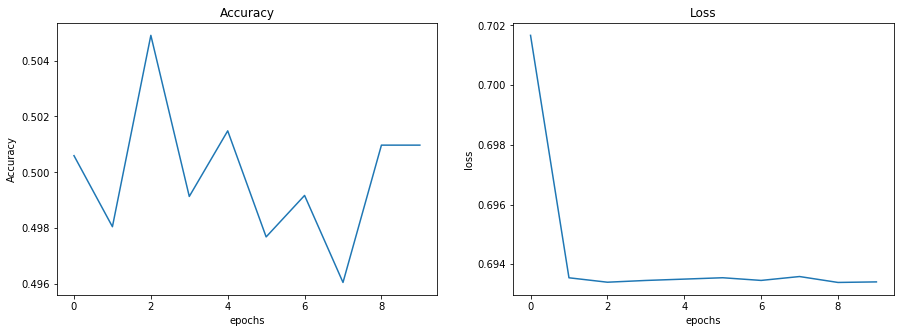

In [96]:
f, (a, b) = plt.subplots(1,2, sharex=False, figsize=(15, 5))

a.plot(ml.history['acc'])
a.set_title('Accuracy')
a.set_xlabel('epochs')
a.set_ylabel('Accuracy')

b.plot(ml.history['loss'])
b.set_title('Loss')
b.set_xlabel('epochs')
b.set_ylabel('loss')


Text(0, 0.5, 'Val_loss')

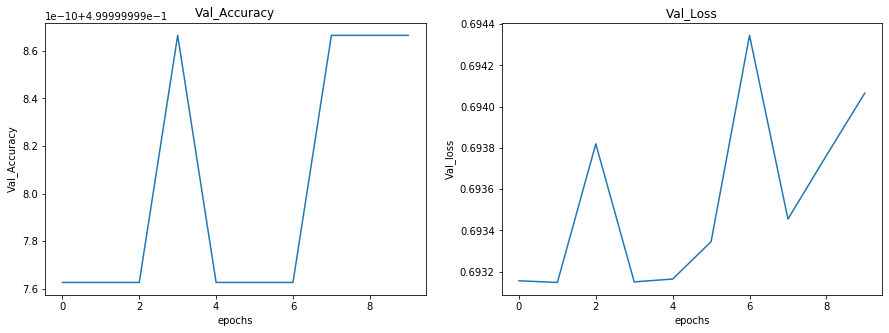

In [97]:
f, (a, b) = plt.subplots(1,2, sharex=False, figsize=(15, 5))

a.plot(ml.history['val_acc'])
a.set_title('Val_Accuracy')
a.set_xlabel('epochs')
a.set_ylabel('Val_Accuracy')

b.plot(ml.history['val_loss'])
b.set_title('Val_Loss')
b.set_xlabel('epochs')
b.set_ylabel('Val_loss')
